 # Reconstrured RecExpSim Notebook

 This is a recreation of the RecExpSim Notebook.
 It should be roughly similar to the existing notebook while using the new restructured codebase.

In [1]:
# Allow imports from the current directory.
import os
import sys
sys.path.append( os.path.abspath(os.path.join('.')) )

# Release only. Disable warnings.
import warnings
warnings.filterwarnings('ignore') # Comment this line to show warnings.

# Release only. Disable the traceback when exceptions occur (like the *_or_abort methods)
import sys
ipython = get_ipython()
def hide_traceback(exc_tuple=None, filename=None, tb_offset=None,
                   exception_only=False, running_compiled_code=False):
    etype, value, tb = sys.exc_info()
    return ipython._showtraceback(etype, value, ipython.InteractiveTB.get_exception_only(etype, value))
ipython.showtraceback = hide_traceback  # Comment this line to show traceback on exceptions.

In [2]:
# 1. Set-up of simulation environment
import os
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
pd.options.display.width = 100 # Make pandas output wider.

from catalog import RecExperiment, combine_data

print('System ready')



System ready


In [3]:
# 2. Lab setup
exp = RecExperiment( equipment_investment=1500, seed=1 )
host = exp.create_host( species='ecol', name="origin" )
# print()
exp.print_status()
host.print_status()



Experiment:
  budget = 8500
  failure rate = 0.12903225806451613
  hosts = [ origin ]
Host [origin]:
  seed plus counter = 4720721261117928062 + 0
  optimal growth temperature = 34
  max biomass = 94
  optimal primer length = 19
  Gene List: 0 genes
  Event History: 0 events


############################################# progress of exp.0 at 22 °C: 100 percent
############################################# progress of exp.1 at 30 °C: 100 percent
############################################# progress of exp.2 at 36 °C: 100 percent
############################################# progress of exp.3 at 40 °C: 100 percent
    time [h]  exp.0 biomass conc. at 22 °C  exp.1 biomass conc. at 30 °C  \
0        0.0                      0.095314                      0.097038   
1        1.0                      0.110892                      0.179248   
2        2.0                      0.098254                      0.479533   
3        3.0                      0.138755                      0.818676   
4        4.0                      0.130351                      1.641986   
5        5.0                      0.108720                      4.236580   
6        6.0                      0.145536                      8.484907   
7        7.0                      0.136456      

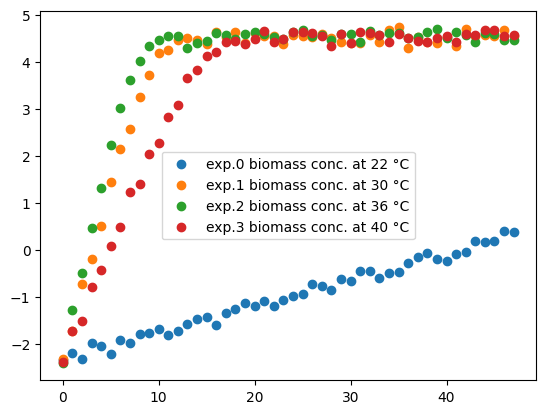

In [4]:
# 3.1. Experiment set-up
temperatures = [22,30,36,40] #[22,24,26,28,30]
# print()
growth_out = exp.simulate_growth("origin", temperatures)
growth_out.display_data()
# growth_out.export_plot('output/Growth_Simulation.png')
growth_out.display_plot()



In [5]:
# 3.2.2.2 Determine maximum biomass and growth rate
Idx_optT, Linear_optT = 2, 6
# TODO: Maybe calculations of MB and GR are hidden inside the Outcome.
#   Maybe its intuitive to draw the chosen point in the plot.
cult_df = growth_out.value
Time, Biomass = cult_df.iloc[:,0], cult_df.iloc[:,1:]
LnBiomass = np.log(Biomass)
MB = np.mean(Biomass.iloc[Linear_optT:,Idx_optT])
GR = np.polyfit(Time.iloc[:Linear_optT],LnBiomass.iloc[:Linear_optT,Idx_optT],1)
print()
print('max biomass: {:.0f}\nmax growth rate: {:.2f}'.format(MB,GR[0]))




max biomass: 90
max growth rate: 0.91


In [6]:
# 4.1.1 Promoter choice and cloning
from silvio.extensions.records.gene.crafted_gene import CraftedGene
from Bio.Seq import Seq
Promoter1 = Seq("GCCCAAAAAAAAAGCAAACACGTAAAGGAAAAAATGCACG")
Primer1 =   Seq("CGGGTTTTTTTTTCGTTTGT")
Tm =        56 # melting temperature
NewGene = CraftedGene( name="MyGenA", prom=Promoter1, orf="GGGGGGGGGG" )

print("\nTry cloning with bad melting temperature.")
# TODO: Melting temperature is not affecting clone chance.
bad_host, clone_outcome = exp.clone_with_recombination( "origin", Primer1, gene=NewGene, tm=1000 )
print("Clone Outcome [{}]: {}".format(bad_host.name,clone_outcome))

print("\nTry cloning first with good parameters.")
good_host_a, clone_outcome = exp.clone_with_recombination( "origin", Primer1, gene=NewGene, tm=Tm )
print("Clone Outcome [{}]: {}".format(good_host_a.name,clone_outcome))
# good_host_a.print_status()

Promoter2 = Seq("GCCCAAATATTAAGCAAACACGTAAAGGAAAAAATGCACG")
Primer2 =   Seq("CGGGTTTATAATTCGTTTGT")
Tm2 =       54
NewGene2 = CraftedGene( name="MyGenB", prom=Promoter2, orf="GGGGGGGGGG" )

print("\nTry cloning second with good parameters.")
good_host_b, clone_outcome = exp.clone_with_recombination( "origin", Primer2, gene=NewGene2, tm=Tm2 )
print("Clone Outcome [{}]: {}".format(good_host_b.name,clone_outcome))
# good_host_b.print_status()

exp.print_status()


Try cloning with bad melting temperature.
Reference primer T:54
Clone Outcome [origin.1]: Primer Failed: Temperature deviation too big.

Try cloning first with good parameters.
Reference primer T:54
Clone Outcome [origin.2]: Cloning with recombination succeeded.

Try cloning second with good parameters.
Reference primer T:54
Clone Outcome [origin.3]: Cloning with recombination succeeded.
Experiment:
  budget = 7800
  failure rate = 0.12903225806451613
  hosts = [ origin.3 , origin , origin.1 , origin.2 ]


In [7]:
good_host_b.print_status()

Host [origin.3]:
  seed plus counter = 5326339429848620559 + 0
  optimal growth temperature = 34
  max biomass = 94
  optimal primer length = 19
  Gene List: 1 genes
  - MyGenB = GCCCAAATATTAAGCAAACACGTAAAGGAAAAAATGCACG * GGGGGGGGGG
  Event History: 1 events
  - - - GenomeLibrary: added gene=MyGenB


In [8]:
# 4.1.2 Measurement of the promoter strength
prom_out_1 = exp.measure_promoter_strength( "origin.1", "MyGenA" )

prom_out_2 = exp.measure_promoter_strength( "origin.2", "MyGenA" )

prom_out_3 = exp.measure_promoter_strength( "origin.3", "MyGenA" ) # Use NewGene but HostB only has NewGene2

prom_out_4 = exp.measure_promoter_strength( "origin.3", "MyGenB" )

# Join all measurements.
print("\nAll Promoter Strengths combined:")
all_prom_out = combine_data([ prom_out_1, prom_out_2, prom_out_3, prom_out_4 ])
all_prom_out.display_data()




All Promoter Strengths combined:
       Host GeneName                              GenePromoter  PromoterStrength
0  origin.1   MyGenA                                      None              0.00
1  origin.2   MyGenA  GCCCAAAAAAAAAGCAAACACGTAAAGGAAAAAATGCACG              1.06
2  origin.3   MyGenA                                      None              0.00
3  origin.3   MyGenB  GCCCAAATATTAAGCAAACACGTAAAGGAAAAAATGCACG              0.72


In [9]:
# 4.1.3 Measurement of the final vaccine expression rate
# in Make_ProductionExperiment: Clone_ID (string), Opt. Temp (int), Opt. Growth rate (float), Opt. Biomass (int)

vac_out_1 = exp.simulate_vaccine_production( ["origin.2"], "MyGenA", cult_temp=26, growth_rate=0.76, biomass=46 )
print('Vaccine production rate A, try 2: (error:{})'.format( vac_out_1.error ))

vac_out_2 = exp.simulate_vaccine_production( ["origin.2"], "MyGenA", cult_temp=36, growth_rate=0.91, biomass=46 )
print('Vaccine production rate A, try 2: (error:{})'.format( vac_out_2.error ))

vac_out_3 = exp.simulate_vaccine_production( ["origin.3"], "MyGenB", cult_temp=36, growth_rate=0.91, biomass=90 )
print('Vaccine production rate B, try 1: (error:{})'.format( vac_out_3.error ))

vac_out_4 = exp.simulate_vaccine_production( ["origin.3"], "MyGenB", cult_temp=36, growth_rate=0.91, biomass=90 )
print('Vaccine production rate B, try 2: (error:{})'.format( vac_out_4.error ))

vac_out_multi = exp.simulate_vaccine_production( ["origin.1", "origin.2", "origin.3"], "MyGenB", cult_temp=36, growth_rate=0.90, biomass=90 )
print('Vaccine production multiple: (error:{})'.format( vac_out_multi.error ))


# Its possible to make a custom combine_data for the production experiments.
all_vac_out = combine_data([ vac_out_1, vac_out_2, vac_out_3, vac_out_4, vac_out_multi ])
all_vac_out.display_data()
all_vac_out.export_data('output/Production_Experiments.csv')



Vaccine production rate A, try 2: (error:None)
Vaccine production rate A, try 2: (error:None)
Vaccine production rate B, try 1: (error:None)
Vaccine production rate B, try 2: (error:None)
Vaccine production multiple: (error:None)
       Host Gene_Name                         Promoter_Sequence  Promoter_GC-content  \
0  origin.2    MyGenA  GCCCAAAAAAAAAGCAAACACGTAAAGGAAAAAATGCACG                0.375   
1  origin.2    MyGenA  GCCCAAAAAAAAAGCAAACACGTAAAGGAAAAAATGCACG                0.375   
2  origin.3    MyGenB  GCCCAAATATTAAGCAAACACGTAAAGGAAAAAATGCACG                0.375   
3  origin.3    MyGenB  GCCCAAATATTAAGCAAACACGTAAAGGAAAAAATGCACG                0.375   
4  origin.1    MyGenB                                       NaN                  NaN   
5  origin.2    MyGenB                                       NaN                  NaN   
6  origin.3    MyGenB  GCCCAAATATTAAGCAAACACGTAAAGGAAAAAATGCACG                0.375   

   Expression_Temperature  Expression_Biomass  Expression_Rate  


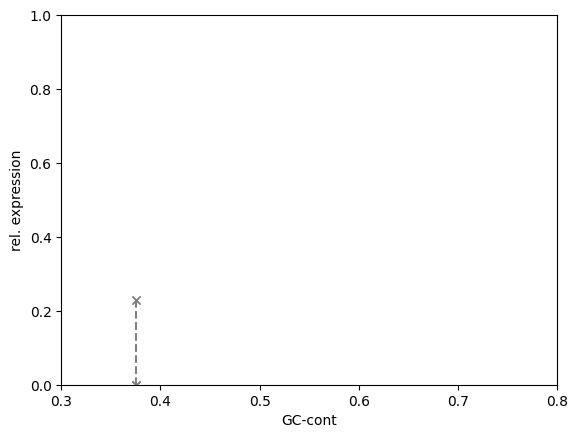

In [10]:
# 4.2.1 Visualization of the results
# TODO: This could be a new DataWithPlotOutcome to hide the code if wanted.
GCcont, Express = all_vac_out.value['Promoter_GC-content'], all_vac_out.value['Expression_Rate']
plt.plot(GCcont,Express, linestyle = '--', marker = 'x', color = 'grey')
plt.gca().set(xlabel='GC-cont', ylabel='rel. expression', xlim=(.3,.8), ylim=(0,1))
plt.savefig('output/RelExpress_Vs_GCcont_allProm.png', format='png')
plt.show()


In [11]:
# Print internal state.
exp.print_status()
for h in exp.hosts :
    h.print_status()

Experiment:
  budget = 4900
  failure rate = 0.12903225806451613
  hosts = [ origin.3 , origin , origin.1 , origin.2 ]
Host [origin.3]:
  seed plus counter = 5326339429848620559 + 0
  optimal growth temperature = 34
  max biomass = 94
  optimal primer length = 19
  Gene List: 1 genes
  - MyGenB = GCCCAAATATTAAGCAAACACGTAAAGGAAAAAATGCACG * GGGGGGGGGG
  Event History: 1 events
  - - - GenomeLibrary: added gene=MyGenB
Host [origin]:
  seed plus counter = 4720721261117928062 + 7
  optimal growth temperature = 34
  max biomass = 94
  optimal primer length = 19
  Gene List: 0 genes
  Event History: 0 events
Host [origin.1]:
  seed plus counter = 6733855923820810057 + 0
  optimal growth temperature = 34
  max biomass = 94
  optimal primer length = 19
  Gene List: 0 genes
  Event History: 0 events
Host [origin.2]:
  seed plus counter = 6259074176465764939 + 0
  optimal growth temperature = 34
  max biomass = 94
  optimal primer length = 19
  Gene List: 1 genes
  - MyGenA = GCCCAAAAAAAAAGCAAACA